In [43]:
import os.path as op
import matplotlib.pyplot as plt
from itertools import compress
import time
import logging
import mne
from mne import events_from_annotations
from collections import OrderedDict
import seaborn as sns
import pingouin as pg


import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from itertools import compress
import mne
import mne_nirs
from mne.preprocessing.nirs import optical_density, beer_lambert_law

from mne_nirs.signal_enhancement import enhance_negative_correlation, short_channel_regression

from mne.preprocessing.nirs import (optical_density,
                                    temporal_derivative_distribution_repair,
                                    scalp_coupling_index)

import ROI
from ROI import different_hb, different_roi
from meta import *
from filter_params import FILTER_DICT
from functions_fnirs import *

def fast_scanfiles(dirname, contains=None):
    subfiles = [f.path for f in os.scandir(dirname) if f.is_file()]
    if contains != None:
        subfiles = [i for i in subfiles if contains in i ]
    return subfiles

SFREQ = 3

In [4]:
from matplotlib.colors import LinearSegmentedColormap

fnirs_colors = dict(
    hbo='#C91111',
    hbt= '#A4C210',
    hbr='#135181',
  )

legend_params_dict = dict(
                            loc='center', 
                            fontsize=11,       
                            borderpad=1.5, 
                            labelspacing=1.5,
                            markerscale=10, 
                            framealpha=0
)

curves_subplot_params = dict(
 top=0.92,
 bottom=0.11,
 left=0.065,
 right=0.945,
 hspace=0.2,
 wspace=0.35
)

two_topomaps_subplot_params = dict(top=0.89,
bottom=0.21,
left=0.115,
right=0.98,
hspace=0.175,
wspace=0.0)

one_topomap_subplot_params = dict(top=0.92,
bottom=0.075,
left=0.105,
right=0.98,
hspace=0.105,
wspace=0.0)


mask_params = dict(marker='o', 
                   markerfacecolor='black', 
                   markeredgecolor='white',
                   linewidth=0, 
                   markersize=6
                   )

color_list = [(0, fnirs_colors['hbr']), (0.5, '#FFFFE4'), (1, fnirs_colors['hbo'])]
custom_cmap = LinearSegmentedColormap.from_list('Custom_cmap', color_list, )

In [5]:
def make_subdicts(haemo_dict, contains):
    new_dict = {key[3:]:value for key, value in haemo_dict.items() if contains in key}
    return new_dict

new_shape = (20, 32, 30)
def concatenate_dicts(haemo_dict, new_shape=new_shape):
    new_dict = {}
    for key in haemo_dict.keys():
        a = np.vstack(haemo_dict[key])
        if new_shape:
            a = a.reshape(new_shape[0], new_shape[1], new_shape[2])
        new_dict[key] = a
    return new_dict

def get_roi_evokeds(new_dict, key, slicer=[7, 14]):
    M1 = new_dict[key].mean(axis=0)[:slicer[0], :].mean(axis=0)
    S1 = new_dict[key].mean(axis=0)[slicer[0]:slicer[1], :].mean(axis=0)
    SMZ = new_dict[key].mean(axis=0)[slicer[1]:, :].mean(axis=0)
    return M1, S1, SMZ

In [6]:
def fast_scanfiles(dirname, contains=None, exclude=[]):
    subfiles = [f.path for f in os.scandir(dirname) if f.is_file()]
    if contains != None:
        subfiles = [i for i in subfiles if contains in i ]
    if exclude != None:
        subfiles = [i for i in subfiles if i.split('/')[-1][0:2] not in exclude ]
    return subfiles

In [7]:
# path_to_haemo = '/home/avaldamon/Desktop/minmaxed/haemodynamics_np'
# topo_dir = '/home/avaldamon/Desktop/minmaxed/topomaps_np/'
topo_dir = '/home/avaldamon/Desktop/intact/topomaps_np/' 
path_to_haemo = '/home/avaldamon/Desktop/intact/haemodynamics_np'

new_shape = (17, 35, 48)
exclude = ['VL', 'DK', 'AL']

# new_shape = (20, 35, 30)
# exclude = []

def concatenate_dicts(haemo_dict, new_shape=new_shape):
    new_dict = {}
    for key in haemo_dict.keys():
        a = np.vstack(haemo_dict[key])
        if new_shape:
            a = a.reshape(new_shape[0], new_shape[1], new_shape[2])
        new_dict[key] = a
    return new_dict

In [8]:
haemo_dict = dict(
    
ME_smr_left = [np.load(i) for i in fast_scanfiles(path_to_haemo,
                                        contains='ME_smr_left', exclude=exclude)],
MI_smr_left = [np.load(i) for i in fast_scanfiles(path_to_haemo,
                                        contains='MI_smr_left', exclude=exclude)],
TS_smr_left = [np.load(i) for i in fast_scanfiles(path_to_haemo,
                                        contains='TS_smr_left', exclude=exclude)],
TI_smr_left = [np.load(i) for i in fast_scanfiles(path_to_haemo,
                                        contains='TI_smr_left', exclude=exclude)],
# SA_smr_left = [np.load(i) for i in fast_scanfiles(path_to_haemo,
#                                         contains='SA_smr_left', exclude=exclude)],

ME_rest_left = [np.load(i) for i in fast_scanfiles(path_to_haemo,
                                        contains='ME_rest_left', exclude=exclude)],
MI_rest_left = [np.load(i) for i in fast_scanfiles(path_to_haemo,
                                        contains='MI_rest_left', exclude=exclude)],
TS_rest_left = [np.load(i) for i in fast_scanfiles(path_to_haemo,
                                        contains='TS_rest_left', exclude=exclude)],
TI_rest_left = [np.load(i) for i in fast_scanfiles(path_to_haemo,
                                        contains='TI_rest_left', exclude=exclude)],
# SA_rest_left = [np.load(i) for i in fast_scanfiles(path_to_haemo,
#                                         contains='SA_rest_left', exclude=exclude)],


ME_smr_right = [np.load(i) for i in fast_scanfiles(path_to_haemo,
                                        contains='ME_smr_right', exclude=exclude)],
MI_smr_right = [np.load(i) for i in fast_scanfiles(path_to_haemo,
                                        contains='MI_smr_right', exclude=exclude)],
TS_smr_right = [np.load(i) for i in fast_scanfiles(path_to_haemo,
                                        contains='TS_smr_right', exclude=exclude)],
TI_smr_right = [np.load(i) for i in fast_scanfiles(path_to_haemo,
                                        contains='TI_smr_right', exclude=exclude)],
# SA_smr_right = [np.load(i) for i in fast_scanfiles(path_to_haemo,
#                                         contains='SA_smr_right', exclude=exclude)],

ME_rest_right = [np.load(i) for i in fast_scanfiles(path_to_haemo,
                                        contains='ME_rest_right', exclude=exclude)],
MI_rest_right = [np.load(i) for i in fast_scanfiles(path_to_haemo,
                                        contains='MI_rest_right', exclude=exclude)],
TS_rest_right = [np.load(i) for i in fast_scanfiles(path_to_haemo,
                                        contains='TS_rest_right', exclude=exclude)],
TI_rest_right = [np.load(i) for i in fast_scanfiles(path_to_haemo,
                                        contains='TI_rest_right', exclude=exclude)],
# SA_rest_right = [np.load(i) for i in fast_scanfiles(path_to_haemo,
#                                         contains='SA_rest_right', exclude=exclude)],
)
subj_n = len(haemo_dict['ME_smr_left'])


ME_subdict = make_subdicts(haemo_dict, contains='ME')
MI_subdict = make_subdicts(haemo_dict, contains='MI')
TS_subdict = make_subdicts(haemo_dict, contains='TS')
TI_subdict = make_subdicts(haemo_dict, contains='TI')
# SA_subdict = make_subdicts(haemo_dict, contains='SA')

ME_subdict = concatenate_dicts(make_subdicts(haemo_dict, contains='ME'))
MI_subdict = concatenate_dicts(make_subdicts(haemo_dict, contains='MI'))
TS_subdict = concatenate_dicts(make_subdicts(haemo_dict, contains='TS'))
TI_subdict = concatenate_dicts(make_subdicts(haemo_dict, contains='TI'))
# SA_subdict = concatenate_dicts(make_subdicts(haemo_dict, contains='SA'))


topo_dict = dict(

ME_topo = [np.load(i) for i in fast_scanfiles(topo_dir,
                                        contains='ME')],
MI_topo = [np.load(i) for i in fast_scanfiles(topo_dir,
                                        contains='MI')],
TS_topo = [np.load(i) for i in fast_scanfiles(topo_dir,
                                        contains='TS')],
TI_topo = [np.load(i) for i in fast_scanfiles(topo_dir,
                                        contains='TI')],
# SA_topo = [np.load(i) for i in fast_scanfiles(topo_dir,
#                                         contains='SA')],
)
huh = concatenate_dicts(topo_dict, new_shape=None)

In [38]:
arr = ME_subdict['smr_left'][:, 0:7, :].mean(axis=1)
arr_mean = np.median(arr, axis=0)
std_arr = np.std(arr, axis=0)

arr_add_std = arr_mean + std_arr
arr_remove_std = arr_mean - std_arr

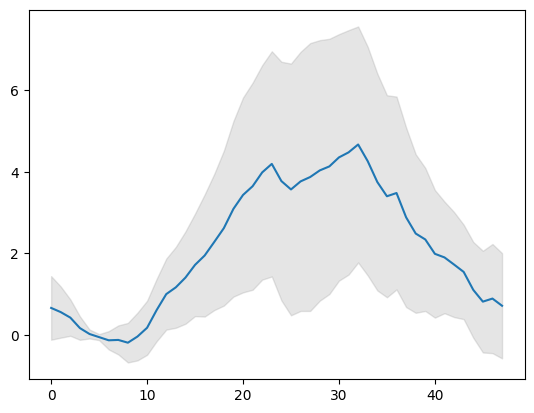

In [40]:
plt.plot(arr_mean)
plt.fill_between(np.arange(arr_mean.shape[0]), arr_remove_std, arr_add_std,
                 color='gray', alpha=0.2)

In [41]:
arr = ME_subdict['smr_left'].mean(axis=0)
arr_mean = np.median(arr[0:7, :], axis=0)
std_arr = np.std(arr, axis=0)

arr_add_std = arr_mean + std_arr
arr_remove_std = arr_mean - std_arr

In [47]:
arr_mean.shape

(48,)

In [49]:
import scipy.stats as st
arr_lower, arr_upper = st.t.interval(alpha=0.90, df=len(arr)-1, 
              loc=np.mean(arr), 
              scale=st.sem(arr)) 

/tmp/ipykernel_6031/4094032929.py:2: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  arr_lower, arr_upper = st.t.interval(alpha=0.90, df=len(arr)-1,


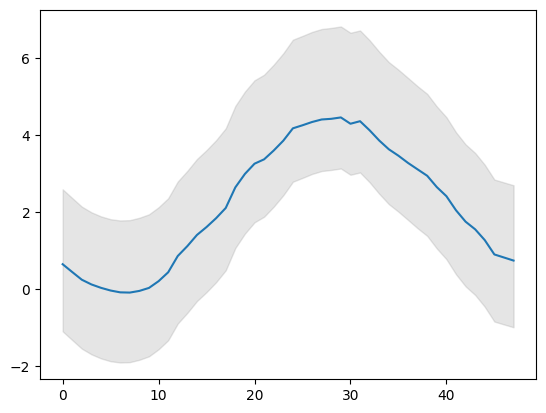

In [51]:
plt.plot(arr_mean)
plt.fill_between(np.arange(arr_mean.shape[0]), arr_mean-arr_lower, arr_mean+arr_upper,
                 color='gray', alpha=0.2)

ValueError: x and y can be no greater than 2D, but have shapes (17,) and (17, 35, 48)

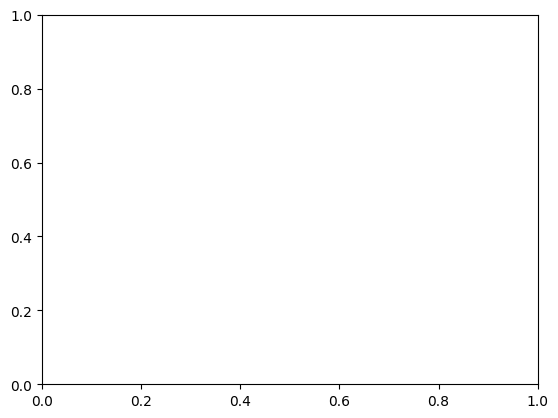

In [17]:
plt.plot(arr)

In [62]:
%matplotlib auto
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

Using matplotlib backend: QtAgg


In [63]:
info_hbr_total = mne.io.read_info("/mnt/diskus/infos/info_hbr_total_info.fif")
info_left_smz = mne.io.read_info("/mnt/diskus/infos/info_left_smz_info.fif")
info_right_smz = mne.io.read_info("/mnt/diskus/infos/info_right_smz_info.fif")
info_hbo_total = mne.io.read_info("/mnt/diskus/infos/info_hbo_total_info.fif")

In [64]:
def get_median_for_stats(subdict, key, window=[5*SFREQ, 12*SFREQ], criterion='median'):
    slicer=[6, 13]
    new_dict = subdict[key][:, :, window[0]:window[1]]
    M1 = new_dict[:, :slicer[0], :].mean(axis=1)
    S1 = new_dict[:, slicer[0]:slicer[1], :].mean(axis=1)
    SMZ = new_dict[:, slicer[1]:, :].mean(axis=1)
    
    if criterion == 'median':
        M1_median = np.median(M1, axis=1)
        S1_median = np.median(S1, axis=1)
        SMZ_median = np.median(SMZ, axis=1)
    if criterion == 'mean':
        M1_median = np.mean(M1, axis=1)
        S1_median = np.mean(S1, axis=1)
        SMZ_median = np.mean(SMZ, axis=1)
    if criterion == 'max':
        M1_median = np.max(M1, axis=1)
        S1_median = np.max(S1, axis=1)
        SMZ_median = np.max(SMZ, axis=1) 

    return M1_median, S1_median, SMZ_median

def get_sliced(subdict, key):
    slicer=[6, 13]
    new_dict = subdict[key]
    M1 = new_dict[:, :slicer[0], :].mean(axis=1)
    S1 = new_dict[:, slicer[0]:slicer[1], :].mean(axis=1)
    SMZ = new_dict[:, slicer[1]:, :].mean(axis=1)
    
    return M1, S1, SMZ

SFREQ = 3
TMIN, TMAX = -2, 14
def get_median(arr, window=[5*SFREQ, 12*SFREQ], criterion='median'):
    
    arr = arr[:, window[0]:window[1]]
    if criterion == 'median':
        arr = np.median(arr, axis=1)

    if criterion == 'mean':
        arr = np.mean(arr, axis=1)

    if criterion == 'max':
        arr = np.max(arr, axis=1)

    return arr

In [65]:
curves_hb = 'hbo'
SUBJECT = 'AVERAGE'
CONDITION_LIST = ['ME', 'MI', 'TI', 'TS']
TOPO_CONDITION_LIST = ['ME_topo', 'MI_topo', 'TI_topo', 'TS_topo']
subdicts = [ME_subdict, MI_subdict, TI_subdict, TS_subdict]
storage = []

SFREQ = 3
TMIN, TMAX = -2, 14

for i in range(len(subdicts)):
    CONDITION = CONDITION_LIST[i]
    subdict = subdicts[i]

    M1_evoked_SMR_left, S1_evoked_SMR_left, SMZ_evoked_SMR_left = get_roi_evokeds(subdict, key='smr_left')
    M1_evoked_REST_left, S1_evoked_REST_left, SMZ_evoked_REST_left = get_roi_evokeds(subdict, key='rest_left')
    M1_evoked_SMR_right, S1_evoked_SMR_right, SMZ_evoked_SMR_right = get_roi_evokeds(subdict, key='smr_right')
    M1_evoked_REST_right, S1_evoked_REST_right, SMZ_evoked_REST_right = get_roi_evokeds(subdict, key='rest_right')

    
    ### PLOT HEMODYNAMICS PER SE ###
    m1_group_left = [info_left_smz.ch_names.index(ch) for ch in different_roi['M1'][0] ]
    s1_group_left = [info_left_smz.ch_names.index(ch) for ch in different_roi['S1'][0] ]
    smz_group_left = [info_left_smz.ch_names.index(ch) for ch in different_roi['REMAINING'][0]]

    m1_group_right = [info_right_smz.ch_names.index(ch) for ch in different_roi['M1'][2] ]
    s1_group_right = [info_right_smz.ch_names.index(ch) for ch in different_roi['S1'][2] ]
    smz_group_right = [info_right_smz.ch_names.index(ch) for ch in different_roi['REMAINING'][2]]

    times = np.arange(TMIN, TMAX, 1/SFREQ)
    linewidth = 1.5
    ylims = (-5, 9)
#     ylims = (0.1, 0.8)
    tmin, tmax = TMIN, TMAX
    topo_linewidth = 1
    pointsize = 20
    topo_width = topo_height = '30%'

    fig, axes = plt.subplots(1, 2, figsize=(20, 12))


    ### LEFT PART ###

    line_m1_smr, = axes[0].plot(times, M1_evoked_SMR_left, label=f'M1/{curves_hb} SMR', 
             color=fnirs_colors['hbr'])
    line_s1_smr, = axes[0].plot(times, S1_evoked_SMR_left, label=f'S1/{curves_hb} SMR', 
             color=fnirs_colors['hbo'])
    line_smz_smr, = axes[0].plot(times, SMZ_evoked_SMR_left, label=f'SMR/{curves_hb} SMR', 
             color=fnirs_colors['hbt'])
    line_m1_rest, = axes[0].plot(times, M1_evoked_REST_left, label=f'M1/{curves_hb} REST', 
             color=fnirs_colors['hbr'], linestyle='--')
    line_s1_rest, = axes[0].plot(times, S1_evoked_REST_left, label=f'S1/{curves_hb} REST', 
             color=fnirs_colors['hbo'], linestyle='--')
    line_smz_rest, = axes[0].plot(times, SMZ_evoked_REST_left, label=f'SMR/{curves_hb} REST', 
             color=fnirs_colors['hbt'], linestyle='--')

    fill_1 = filler_between(axes[0], ylims)

    set_axis_properties(axes[0],
                        ylims=ylims, 
                        tlims=(tmin, tmax), 
                        title=f'HbO response in LEFT hemisphere\n {SUBJECT} in {subj_n} subjects, Condition {CONDITION}',
                        xlabel='Time, s', 
                        ylabel='Hb concentration, Δ μM\L',  
                        linewidth=1.5, 
                        fontsize=14, 
                        title_size=18,
                        legend_flag=False
                            )
    ### LEFT HEMO TOPOMAP ###
    inset_ax1 = inset_axes(axes[0], width=topo_width, height=topo_height, loc="lower right")
    mne.viz.plot_sensors(info_left_smz, 
                         ch_groups=[  m1_group_left, 
                                     smz_group_left,
                                    s1_group_left],
                         axes=inset_ax1,
                         pointsize=pointsize, 
                         linewidth=topo_linewidth)

    ### RIGHT PART ###
    axes[1].plot(times, M1_evoked_SMR_right, label=f'M1/{curves_hb} SMR', 
             color=fnirs_colors['hbr'])
    axes[1].plot(times, S1_evoked_SMR_right, label=f'S1/{curves_hb} SMR', 
             color=fnirs_colors['hbo'])
    axes[1].plot(times, SMZ_evoked_SMR_right, label=f'SMR/{curves_hb} SMR', 
             color=fnirs_colors['hbt'])
    axes[1].plot(times, M1_evoked_REST_right, label=f'M1/{curves_hb} REST', 
             color=fnirs_colors['hbr'], linestyle='--')
    axes[1].plot(times, S1_evoked_REST_right, label=f'S1/{curves_hb} REST', plt.plot(xdata, ydata, 'or')
             color=fnirs_colors['hbo'], linestyle='--')
    axes[1].plot(times, SMZ_evoked_REST_right, label=f'SMR/{curves_hb} REST', 
             color=fnirs_colors['hbt'], linestyle='--')

    fill_2 = filler_between(axes[1], ylims)


    set_axis_properties(axes[1],
                        ylims=ylims, 
                        tlims=(tmin, tmax), 
                        title=f'HbO response in RIGHT hemisphere\n {SUBJECT} in {subj_n} subjects, Condition {CONDITION}',
                        xlabel='Time, s', 
                        ylabel='',  
                        linewidth=1.5, 
                        fontsize=14, 
                        title_size=18,
                        legend_flag=False,
                            )

    ### RIGHT HEMO TOPOMAP ###
    inset_ax2 = inset_axes(axes[1], width=topo_width, height=topo_height, loc="lower right")
    mne.viz.plot_sensors(
                        info_right_smz, 
                        ch_groups=[
                                    m1_group_right, 
                                    smz_group_right,
                                    s1_group_right],
                        axes=inset_ax2, plt.plot(xdata, ydata, 'or')plt.plot(xdata, ydata, 'or')
                        pointsize=pointsize, 
                        linewidth=topo_linewidth)


    ### LEGENDS PARAMS ###
    ax_legend = fig.add_axes([0.25, 0.25, 0.5, 0.25])
    ax_legend.legend([line_m1_smr, line_s1_smr, line_smz_smr,
                     line_m1_rest, line_s1_rest, line_smz_rest, fill_1], 
                     [f'M1/{curves_hb} SMR', f'S1/{curves_hb} SMR', f'SMZ/{curves_hb} SMR', 
                      f'M1/{curves_hb} REST', f'S1/{curves_hb} REST',f'SMZ/{curves_hb} REST',
                     'Task duration'], 
                    **legend_params_dict) 

    ax_legend.set_frame_on(False)
    ax_legend.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    plt.subplots_adjust(**curves_subplot_params)
#     plt.close()


    plt.savefig(f'/home/avaldamon/Desktop/HAEMO_{CONDITION}.png')


    subdict_topo = huh[TOPO_CONDITION_LIST[i]]
    mean_topos = subdict_topo.mean(axis=0)

    smr_in_peak_timestamp = mean_topos[:102]
    rest_in_peak_timestamp = mean_topos[102:]
    
    
    top_n_chans = 10
    mask_SMR, top_dict_SMR = get_top_channels_mask(smr_in_peak_timestamp, 
                                                    info_hbo_total, 
                                                    top_n_chans)
    mask_REST, top_dict_REST = get_top_channels_mask(rest_in_peak_timestamp, 
                                                    info_hbo_total, 
                                                    top_n_chans)



    ylims = (-3, 8)
#     ylims = (0.2, 0.6)

    fig, axes = plt.subplots(1, 2, figsize=(20, 12))

    ### LEFT SMR TOPO ###
    a = mne.viz.plot_topomap(data=smr_in_peak_timestamp,
                            pos=info_hbo_total,
                            axes=axes[0],
                            vlim=ylims,
                            contours=6,
                            extrapolate='local',
                            image_interp='linear',
                            cmap=custom_cmap, 
                            mask=mask_SMR,
                            mask_params=mask_params,
                            show=False)
    ### RIGHT REST TOPO ###
    a = mne.viz.plot_topomap(data=rest_in_peak_timestamp,
                            pos=info_hbo_total,
                            axes=axes[1],
                            vlim=ylims,
                            contours=6,
                            extrapolate='local',
                            image_interp='linear',
                            cmap=custom_cmap,
                            mask=mask_REST,
                            mask_params=mask_params, 
                            show=False)

    ### TITLES ###
    axes[0].set_title(
            f'Topography of {curves_hb} in {SUBJECT}, {subj_n} subjects\n in {CONDITION} condititon',
    fontsize=18)

    axes[1].set_title(
            f'Topography of {curves_hb} in {SUBJECT}, {subj_n} subjects \n in REST condititon',
    fontsize=18)

    ### COLORBAR SETTINGS ###
    sm = plt.cm.ScalarMappable(cmap=custom_cmap, 
                            norm=matplotlib.colors.Normalize(vmin=ylims[0], vmax=ylims[1]))

    cbaxes = fig.add_axes([0.075, 0.25, 0.02, 0.5]) # setup colorbar axes. 
    cbar = plt.colorbar(mappable=sm, cax=cbaxes, pad=0.15, orientation='vertical')
    cbar.set_label(' Hb concentration, Δ μM\L', loc='center', size=12)
    cbar.ax.yaxis.set_label_coords(-0.5, 0.5)
    plt.subplots_adjust(**two_topomaps_subplot_params)
    
    plt.savefig(f'/home/avaldamon/Desktop/TOPO_{CONDITION}.png')
    
    storage.append(smr_in_peak_timestamp)

#     plt.close()

In [168]:
import pandas as pd
import re

def parse_log_entry(entry):
    split_entries = entry.split('\n')
    SUBJ = split_entries[0][-2:]
    COND = split_entries[1][-2:]
    TMAX = split_entries[3].split(' ')[-1]

    return SUBJ, COND, TMAX

# Read log file
log_file = '/home/avaldamon/Desktop/intact/log_runtime.txt'
with open(log_file, 'r') as f:
    log_text = f.read()

# Split log text into entries
log_entries = re.split(r'##########\n', log_text)

df_dict = dict(SUBJ=[],
              COND=[],
              TMAX=[])

for entry in range(0, len(log_entries)-1, 2):
    entry = log_entries[entry]
    SUBJ, COND, TMAX = parse_log_entry(entry)
    print(SUBJ, COND, TMAX)
    df_dict['SUBJ'].append(SUBJ)
    df_dict['COND'].append(COND)
    df_dict['TMAX'].append(TMAX)
# Parse each entry and store in a list

# Create a DataFrame from the parsed entries
df = pd.DataFrame(df_dict).round(1)


AA ME 8.666666666666666
AA MI 8.666666666666666
AA SA 11.0
AA TI 10.666666666666666
AA TS 15.0
AB ME 8.333333333333334
AB MI 10.333333333333334
AB SA 10.333333333333334
AB TI 11.666666666666666
AB TS 9.666666666666666
AL ME 14.666666666666666
AL MI 10.666666666666666
AL SA 10.333333333333334
AL TI 12.333333333333334
AL TS 11.333333333333334
AM ME 6.333333333333333
AM MI 8.333333333333334
AM SA 8.333333333333334
AM TI 10.333333333333334
AM TS 6.333333333333333
DK ME 15.0
DK MI 7.666666666666667
DK SA 11.666666666666666
DK TI -0.6666666666666666
DK TS 4.0
DT ME 13.666666666666666
DT MI 6.333333333333333
DT SA 15.0
DT TI 11.0
DT TS -0.6666666666666666
EI ME 9.0
EI MI 8.0
EI SA 7.333333333333333
EI TI 8.666666666666666
EI TS 13.333333333333334
ET ME 8.0
ET MI 8.333333333333334
ET SA 7.333333333333333
ET TI 10.333333333333334
ET TS 4.333333333333333
GF ME 8.666666666666666
GF MI 12.0
GF SA 10.666666666666666
GF TI 5.666666666666667
GF TS 9.333333333333334
IM ME 10.666666666666666
IM MI 11.0

In [169]:
pivot_df = df.pivot_table(index='SUBJ', columns='COND', values='TMAX', aggfunc='first')

# pivot_df.reset_index(inplace=True)

pivot_df.to_csv('/home/avaldamon/Desktop/times_intact.csv')

In [118]:
for i in log_entries:
    print(i)
    print('-'*8)

2024-02-11 13:30:55,410 AA
2024-02-11 13:30:55,410 ME
2024-02-11 13:30:55,410 ['S12_D11 760', 'S25_D28 760', 'S14_D15 760', 'S23_D18 760', 'S15_D18 760', 'S12_D9 760', 'S26_D29 760', 'S32_D28 760', 'S8_D15 760', 'S12_D15 760', 'S12_D11 850', 'S25_D28 850', 'S14_D15 850', 'S23_D18 850', 'S15_D18 850', 'S12_D9 850', 'S26_D29 850', 'S32_D28 850', 'S8_D15 850', 'S12_D15 850']
2024-02-11 13:30:55,410 8.666666666666666
2024-02-11 13:30:55,410 right
2024-02-11 13:30:55,410 10.666666666666666
2024-02-11 13:30:55,411 left
2024-02-11 13:30:55,411 OrderedDict([('S11_D14 hbo', 10.393007403634119), ('S9_D13 hbo', 7.838662394210326), ('S12_D9 hbo', 7.531438992312935), ('S10_D13 hbo', 6.7935882220282755), ('S16_D18 hbo', 6.5170944220268305), ('S14_D15 hbo', 6.474581286246765), ('S31_D30 hbo', 6.187912014983956), ('S12_D14 hbo', 6.017850584042796), ('S16_D13 hbo', 5.876902423839762), ('S11_D17 hbo', 5.703659363022869)])
2024-02-11 13:30:55,411 OrderedDict([('S9_D13 hbo', 5.157964028125447), ('S10_D13 

In [113]:
i = 2
split_entries = log_entries[i].split('\n')
SUBJ = split_entries[0][-2:]
COND = split_entries[1][-2:]
TMAX = split_entries[3].split(' ')[-1]

print(SUBJ, COND, TMAX)

AA MI 8.666666666666666


In [95]:
for i in log_entries:
    print(i)

2024-02-11 13:30:55,410 AA
2024-02-11 13:30:55,410 ME
2024-02-11 13:30:55,410 ['S12_D11 760', 'S25_D28 760', 'S14_D15 760', 'S23_D18 760', 'S15_D18 760', 'S12_D9 760', 'S26_D29 760', 'S32_D28 760', 'S8_D15 760', 'S12_D15 760', 'S12_D11 850', 'S25_D28 850', 'S14_D15 850', 'S23_D18 850', 'S15_D18 850', 'S12_D9 850', 'S26_D29 850', 'S32_D28 850', 'S8_D15 850', 'S12_D15 850']
2024-02-11 13:30:55,410 8.666666666666666
2024-02-11 13:30:55,410 right
2024-02-11 13:30:55,410 10.666666666666666
2024-02-11 13:30:55,411 left
2024-02-11 13:30:55,411 OrderedDict([('S11_D14 hbo', 10.393007403634119), ('S9_D13 hbo', 7.838662394210326), ('S12_D9 hbo', 7.531438992312935), ('S10_D13 hbo', 6.7935882220282755), ('S16_D18 hbo', 6.5170944220268305), ('S14_D15 hbo', 6.474581286246765), ('S31_D30 hbo', 6.187912014983956), ('S12_D14 hbo', 6.017850584042796), ('S16_D13 hbo', 5.876902423839762), ('S11_D17 hbo', 5.703659363022869)])
2024-02-11 13:30:55,411 OrderedDict([('S9_D13 hbo', 5.157964028125447), ('S10_D13 

In [14]:
def relation(arr_target, arr_rest):
    return arr_target - arr_rest


In [15]:
curves_hb = 'hbo'
SUBJECT = 'AVERAGE'
CONDITION_LIST = ['ME', 'MI', 'TS', 'TI']
TOPO_CONDITION_LIST = ['ME_topo', 'MI_topo', 'TS_topo', 'TI_topo',]
subdicts = [ME_subdict, MI_subdict, TI_subdict, TS_subdict]

df = pd.DataFrame()

for i in range(len(subdicts)):
    CONDITION = CONDITION_LIST[i]
    subdict = subdicts[i]
        
    print(type(subdict))
    
    M1_evoked_SMR_left, S1_evoked_SMR_left, SMZ_evoked_SMR_left = get_sliced(subdict, key='smr_left')
    M1_evoked_REST_left, S1_evoked_REST_left, SMZ_evoked_REST_left = get_sliced(subdict, key='rest_left')
    M1_evoked_SMR_right, S1_evoked_SMR_right, SMZ_evoked_SMR_right = get_sliced(subdict, key='smr_right')
    M1_evoked_REST_right, S1_evoked_REST_right, SMZ_evoked_REST_right = get_sliced(subdict, key='rest_right')
    

#     M1_left_median, S1_left_median, SMZ_left_median = M1_evoked_SMR_left/M1_evoked_REST_left, \
#                                                       S1_evoked_SMR_left/S1_evoked_REST_left, \
#                                                       SMZ_evoked_SMR_left/SMZ_evoked_REST_left
#     M1_right_median, S1_right_median, SMZ_right_median = M1_evoked_SMR_right/M1_evoked_REST_right, \
#                                                       S1_evoked_SMR_right/S1_evoked_REST_right, \
#                                                       SMZ_evoked_SMR_right/SMZ_evoked_REST_right
    
    M1_left_median, S1_left_median, SMZ_left_median = get_median(relation(M1_evoked_SMR_left, M1_evoked_REST_left)), \
                                                      get_median(relation(S1_evoked_SMR_left, S1_evoked_REST_left)), \
                                                      get_median(relation(SMZ_evoked_SMR_left, SMZ_evoked_REST_left))
    M1_right_median, S1_right_median, SMZ_right_median = get_median(relation(M1_evoked_SMR_right, M1_evoked_REST_right)), \
                                                      get_median(relation(S1_evoked_SMR_right, S1_evoked_REST_right)), \
                                                      get_median(relation(SMZ_evoked_SMR_right, SMZ_evoked_REST_right))
    
    
    print(M1_left_median.shape)

    df[f'{CONDITION}_M1_left'] = M1_left_median
#     df[f'{CONDITION}_M1_right'] = M1_right_median
    
    df[f'{CONDITION}_S1_left'] = S1_left_median
#     df[f'{CONDITION}_S1_right'] = S1_right_median

    df[f'{CONDITION}_SMZ_left'] = SMZ_left_median
#     df[f'{CONDITION}_SMZ_right'] = SMZ_right_median

    #     print(np.median(M1_evoked_SMR_left[5*SFREQ:14*SFREQ]) / np.median(M1_evoked_REST_left[5*SFREQ:14*SFREQ]))
#     print(np.median(S1_evoked_SMR_left[5*SFREQ:14*SFREQ]) / np.median(S1_evoked_REST_left[5*SFREQ:14*SFREQ]))

<class 'dict'>
(17,)
<class 'dict'>
(17,)
<class 'dict'>
(17,)
<class 'dict'>
(17,)


In [16]:
df

,ME_M1_left,ME_S1_left,ME_SMZ_left,MI_M1_left,MI_S1_left,MI_SMZ_left,TS_M1_left,TS_S1_left,TS_SMZ_left,TI_M1_left,TI_S1_left,TI_SMZ_left
0,0.131150,0.109816,0.128754,0.168297,0.208729,0.211813,0.087888,0.208896,0.157918,0.185597,0.170362,0.196213
1,0.113077,0.137845,0.122484,0.233944,0.158056,0.172332,0.204722,0.226261,0.220500,0.060926,0.062564,0.070030
2,0.103068,0.121081,0.082772,0.276688,0.199411,0.241271,0.108298,0.068774,0.133038,0.104165,0.036133,0.123287
3,0.177343,0.209885,0.204841,-0.191076,-0.320388,-0.262079,-0.058821,0.014442,-0.033068,0.177751,0.131747,0.141143
4,0.116430,0.235555,0.197317,0.290750,0.239605,0.260708,0.118813,0.169760,0.128967,0.163882,0.086348,0.128460
5,0.117939,0.146698,0.146953,0.089680,0.113080,0.144784,0.214633,0.228434,0.192899,-0.053312,-0.026551,-0.029724
6,-0.014832,-0.076368,-0.075822,0.146193,0.079483,0.120673,0.178392,0.103215,0.132319,0.170553,0.122096,0.134553
7,0.162434,0.168495,0.185445,0.104617,0.038686,0.052049,-0.139809,-0.200865,-0.174534,-0.264781,-0.349439,-0.308900
8,-0.027716,-0.108946,-0.082004,0.058948,-0.040248,0.000789,0.189890,0.021721,0.046906,0.239752,0.199491,0.219691
9,0.172432,0.170981,0.174429,0.183923,0.259663,0.202649,0.183378,0.240122,0.210799,0.131078,0.132670,0.153428


In [220]:
import pandas as pd
import scipy.stats as stats

def check_normality_and_dispersion(data):
    """
    Check normality and dispersion of data columns.

    Parameters:
        data (DataFrame): Input DataFrame with columns containing the data to check.

    Returns:
        DataFrame: DataFrame containing normality and dispersion measures for each column.
    """
    results = pd.DataFrame(columns=['Normality Test', 'p-value', 'Skewness', 'Kurtosis', 'Variance'])

    for column in data.columns:
        # Normality test
        stat, p_value = stats.normaltest(data[column])
        if p_value < 0.05:
            normality_result = 'Not Normal'
        else:
            normality_result = 'Normal'

        # Skewness and kurtosis
        skewness = data[column].skew()
        kurtosis = data[column].kurtosis()

        # Dispersion (variance)
        variance = data[column].var()

        results.loc[column] = [normality_result, p_value, skewness, kurtosis, variance]

    return results


result_df = check_normality_and_dispersion(df)
result_df

/home/avaldamon/.cache/pypoetry/virtualenvs/fnirs-pEil43oO-py3.8/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/avaldamon/.cache/pypoetry/virtualenvs/fnirs-pEil43oO-py3.8/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/avaldamon/.cache/pypoetry/virtualenvs/fnirs-pEil43oO-py3.8/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/avaldamon/.cache/pypoetry/virtualenvs/fnirs-pEil43oO-py3.8/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1772: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18


,Normality Test,p-value,Skewness,Kurtosis,Variance
ME_M1_left,Normal,0.444624,-0.663277,-0.246177,0.025879
ME_S1_left,Normal,0.239000,0.662206,1.049792,0.014183
ME_SMZ_left,Normal,0.627517,0.277335,0.616748,0.012690
MI_M1_left,Normal,0.149625,-0.537993,-1.233123,0.013808
MI_S1_left,Normal,0.790898,0.340775,-0.332842,0.016215
MI_SMZ_left,Normal,0.226156,-0.073981,-1.264108,0.016155
TS_M1_left,Normal,0.683919,-0.440066,-0.333912,0.015383
TS_S1_left,Normal,0.514655,-0.595644,-0.282824,0.016095
TS_SMZ_left,Normal,0.386224,-0.722118,-0.154218,0.014039
TI_M1_left,Normal,0.701741,-0.401685,0.068085,0.014529


In [221]:
import pingouin as pg
paired_ttest_result = pg.wilcoxon(df['ME_M1_left'], df['MI_M1_left'])
paired_ttest_result

,W-val,alternative,p-val,RBC,CLES
Wilcoxon,49.0,two-sided,0.118706,0.426901,0.712963


In [222]:
sns.boxplot(df, )
plt.axhline(y=0, color='black', linestyle='--')
plt.subplots_adjust(top=0.97,
bottom=0.095,
left=0.04,
right=0.975,
hspace=0.16,
wspace=0.175)

In [161]:
p_values = pd.DataFrame(index=df.columns, columns=df.columns)
p_values

,ME_M1_left,ME_S1_left,ME_SMZ_left,MI_M1_left,MI_S1_left,MI_SMZ_left,TS_M1_left,TS_S1_left,TS_SMZ_left,TI_M1_left,TI_S1_left,TI_SMZ_left
ME_M1_left,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ME_S1_left,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ME_SMZ_left,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MI_M1_left,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MI_S1_left,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MI_SMZ_left,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TS_M1_left,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TS_S1_left,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TS_SMZ_left,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TI_M1_left,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [204]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg

def paired_ttest_heatmaps(df):
    """
    Calculate paired t-test p-values and Cohen's d values for each pair of columns in a DataFrame
    and organize them into two heatmaps.

    Parameters:
        df (DataFrame): Input DataFrame with numeric columns.

    Returns:
        None (displays two heatmaps).
    """
    # Initialize empty DataFrames to store p-values and Cohen's d values
    p_values = pd.DataFrame(index=df.columns, columns=df.columns)
    cohen_d = pd.DataFrame(index=df.columns, columns=df.columns)

    # Calculate paired t-test p-values and Cohen's d values for each pair of columns
    for col1 in df.columns:
        for col2 in df.columns:
            if col1 != col2:
                paired_ttest_result = pg.ttest(df[col1], df[col2], paired=True)
                p_values.loc[col1, col2] = paired_ttest_result['p-val'][0]
                cohen_d.loc[col1, col2] = paired_ttest_result['cohen-d'][0]

    # Convert p-values to colors for the p-values heatmap
    p_values_colors = p_values.applymap(lambda x: 'green' if x < 0.05 else 'red')

    # Convert Cohen's d values to colors for the Cohen's d heatmap
    cohen_d_colors = cohen_d.applymap(lambda x: 'green' if abs(x) > 0.5 else 'red')
    
    p_values.fillna(1, inplace=True)
    cohen_d.fillna(0, inplace=True)

#     plt.figure(figsize=(10, 8))
#     sns.heatmap(p_values, cmap=p_values_colors, annot=True, fmt=".3f", cbar=False)
#     plt.title("Paired t-test p-values Heatmap")
#     plt.show()

#     plt.figure(figsize=(10, 8))
#     sns.heatmap(cohen_d, cmap=cohen_d_colors, annot=True, fmt=".3f", cbar=False)
#     plt.title("Cohen's d Heatmap")
#     plt.show()
    
    return p_values, cohen_d

# Example usage:
p_values, cohen = paired_ttest_heatmaps(df)

In [208]:
vmin, vmax = 0.001, 0.1
p_values
sns.heatmap(p_values, vmin=vmin, vmax=vmax, cmap='viridis', annot=True, fmt=".3f", cbar=True)


<AxesSubplot: >

In [209]:
vmin, vmax = 0.4, 0.8

sns.heatmap(cohen, vmin=vmin, vmax=vmax, cmap='viridis', annot=True, fmt=".3f", cbar=True)

<AxesSubplot: >

In [62]:
from scipy.stats import wilcoxon, ttest_rel
arr1, arr2 = df['ME_M1_left'], df['TS_M1_left']

wilc, p = wilcoxon(arr1, arr2)

In [113]:
%matplotlib auto

Using matplotlib backend: QtAgg


Relation plotting

In [119]:
pngs_minmaxed = sorted(fast_scanfiles('/home/avaldamon/Desktop/minmaxed folders/', 'minmaxed.png'))
pngs_intact = sorted(fast_scanfiles('/home/avaldamon/Desktop/minmaxed folders/', 'intact.png'))

In [124]:
('_').join(pngs_minmaxed[0].split('/')[-1].split('_')[0:2])

'HAEMO_ME'

In [125]:
from PIL import Image
#Read the two images

for i in range(len(pngs_intact)):
    name = ('_').join(pngs_intact[i].split('/')[-1].split('_')[0:2])
    image1 = Image.open(pngs_intact[i])
    image2 = Image.open(pngs_minmaxed[i])
    #resize, first image
    image1_size = image1.size
    new_image = Image.new('RGB',(2*image1_size[0], image1_size[1]), (250,250,250))
    new_image.paste(image1,(0,0))
    new_image.paste(image2,(image1_size[0],0))
    new_image.save(f'/home/avaldamon/Desktop/JOINT_{name}.png',"PNG")

In [133]:
path_to_haemo = '/mnt/diskus/fnirs-data-analysis-git/relation_np/'

haemo_rel_dict = dict(
    
ME_rel_left = [np.load(i) for i in fast_scanfiles(path_to_haemo,
                                        contains='ME_rel_left')],
MI_rel_left = [np.load(i) for i in fast_scanfiles(path_to_haemo,
                                        contains='MI_rel_left')],
TS_rel_left = [np.load(i) for i in fast_scanfiles(path_to_haemo,
                                        contains='TS_rel_left')],
TI_rel_left = [np.load(i) for i in fast_scanfiles(path_to_haemo,
                                        contains='TI_rel_left')],
SA_rel_left = [np.load(i) for i in fast_scanfiles(path_to_haemo,
                                        contains='SA_rel_left')],



ME_rel_right = [np.load(i) for i in fast_scanfiles(path_to_haemo,
                                        contains='ME_rel_right')],
MI_rel_right = [np.load(i) for i in fast_scanfiles(path_to_haemo,
                                        contains='MI_rel_right')],
TS_rel_right = [np.load(i) for i in fast_scanfiles(path_to_haemo,
                                        contains='TS_rel_right')],
TI_rel_right = [np.load(i) for i in fast_scanfiles(path_to_haemo,
                                        contains='TI_rel_right')],
SA_rel_right = [np.load(i) for i in fast_scanfiles(path_to_haemo,
                                        contains='SA_rel_right')],

)


ME_rel_subdict = concatenate_dicts(make_subdicts(haemo_rel_dict, contains='ME'), new_shape=(20, 3, 30))
MI_rel_subdict = concatenate_dicts(make_subdicts(haemo_rel_dict, contains='MI'), new_shape=(20, 3, 30))
TS_rel_subdict = concatenate_dicts(make_subdicts(haemo_rel_dict, contains='TS'), new_shape=(20, 3, 30))
TI_rel_subdict = concatenate_dicts(make_subdicts(haemo_rel_dict, contains='TI'), new_shape=(20, 3, 30))
SA_rel_subdict = concatenate_dicts(make_subdicts(haemo_rel_dict, contains='SA'), new_shape=(20, 3, 30))

In [134]:
curves_hb = 'hbo'
SUBJECT = 'AVERAGE'
CONDITION = 'TI'
subdict = TI_rel_subdict

relation_M1_left, relation_S1_left, relation_SMZ_left = get_roi_evokeds(subdict, key='rel_left', slicer=[1, 2])
relation_M1_right, relation_S1_right, relation_SMZ_right = get_roi_evokeds(subdict, key='rel_right', slicer=[1, 2])

In [135]:
fig, axes = plt.subplots(1, 2, figsize=(20, 12))
times = np.arange(TMIN, TMAX, 1/2)
linewidth = 1.5
ylims=(-3000, 5000)
tmin, tmax = TMIN, TMAX
topo_linewidth = 1
pointsize = 20
topo_width = topo_height = '30%'



### RELATION RIGHT ####

rel_line_m1_smr, = axes[0].plot(times, relation_M1_left, label=f'M1/{curves_hb} SMR', 
        color=fnirs_colors['hbr'])
rel_line_s1_smr, = axes[0].plot(times, relation_S1_left, label=f'S1/{curves_hb} SMR', 
        color=fnirs_colors['hbo'])
rel_line_smz_smr, = axes[0].plot(times, relation_SMZ_left, label=f'SMR/{curves_hb} SMR', 
        color=fnirs_colors['hbt'])

fill_1 = filler_between(axes[0], ylims)

set_axis_properties(
                        axes[0],
                        ylims=ylims, 
                        tlims=(tmin, tmax), 
                        title=f'HbO relation in LEFT hemisphere\n{SUBJECT} in 17 subjects, Condition {CONDITION}',
                        xlabel='Time, s', 
                        ylabel='Hb relation SMR/REST, %',  
                        linewidth=1.5, 
                        fontsize=14, 
                        title_size=18,
                        legend_flag=False
                        )

### TOPO FOR LEFT RELATION PICTURE ###
inset_ax1 = inset_axes(axes[0], 
                        width=topo_width, 
                        height=topo_height, 
                        loc="lower right")

mne.viz.plot_sensors(
                        info_left_smz, 
                        ch_groups=[
                                        m1_group_left, 
                                        smz_group_left,
                                        s1_group_left
                        ],
                        axes=inset_ax1,
                        pointsize=pointsize, 
                        linewidth=topo_linewidth
)

### RELATION RIGHT ###

axes[1].plot(times, relation_M1_right, label=f'M1/{curves_hb} SMR', 
        color=fnirs_colors['hbr'])
axes[1].plot(times, relation_S1_right, label=f'S1/{curves_hb} SMR', 
        color=fnirs_colors['hbo'])
axes[1].plot(times, relation_SMZ_right, label=f'SMR/{curves_hb} SMR', 
        color=fnirs_colors['hbt'])


fill_1 = filler_between(axes[1], ylims)

set_axis_properties(
                        axes[1],
                        ylims=ylims, 
                        tlims=(tmin, tmax), 
                        title=f'HbO relation in RIGHT hemisphere\n{SUBJECT} in 17 subjects, Condition {CONDITION}',
                        xlabel='Time, s', 
                        ylabel='',  
                        linewidth=1.5, 
                        fontsize=14, 
                        title_size=18,
                        legend_flag=False
)

### TOPO FOR RIGHT RELATION PICTURE ###
inset_ax2 = inset_axes(axes[1], width=topo_width, height=topo_height, loc="lower right")
mne.viz.plot_sensors(info_right_smz, 
                        ch_groups=[m1_group_right, 
                                smz_group_right,
                                s1_group_right],
                        axes=inset_ax2, 
                        pointsize=pointsize, 
                        linewidth=topo_linewidth)

### LEGEND PARAMS ###
ax_legend = fig.add_axes([0.25, 0.25, 0.5, 0.25])
ax_legend.legend([rel_line_m1_smr, rel_line_s1_smr, rel_line_smz_smr, fill_1], 
                [f'M1 {curves_hb} relation', 
                f'S1 {curves_hb} relation', 
                f'SMZ {curves_hb} relation', 
                'Task duration'], 
                **legend_params_dict) 

ax_legend.set_frame_on(False)
ax_legend.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.subplots_adjust(**curves_subplot_params)



Plot rest and smr topomaps

In [136]:
topo_dir = '/mnt/diskus/fnirs-data-analysis-git/topomaps_np'
topo_dict = dict(
    
ME_topo = [np.load(i) for i in fast_scanfiles(topo_dir,
                                        contains='ME')],
MI_topo = [np.load(i) for i in fast_scanfiles(topo_dir,
                                        contains='MI')],
TS_topo = [np.load(i) for i in fast_scanfiles(topo_dir,
                                        contains='TS')],
TI_topo = [np.load(i) for i in fast_scanfiles(topo_dir,
                                        contains='TI')],
SA_topo = [np.load(i) for i in fast_scanfiles(topo_dir,
                                        contains='SA')],
)
huh = concatenate_dicts(topo_dict, new_shape=None)

In [137]:
topo_dir = '/mnt/diskus/fnirs-data-analysis-git/topomaps_np'
topo_dict = dict(
    
ME_topo = [np.load(i) for i in fast_scanfiles(topo_dir,
                                        contains='ME')],
MI_topo = [np.load(i) for i in fast_scanfiles(topo_dir,
                                        contains='MI')],
TS_topo = [np.load(i) for i in fast_scanfiles(topo_dir,
                                        contains='TS')],
TI_topo = [np.load(i) for i in fast_scanfiles(topo_dir,
                                        contains='TI')],
SA_topo = [np.load(i) for i in fast_scanfiles(topo_dir,
                                        contains='SA')],
)
huh = concatenate_dicts(topo_dict, new_shape=None)

curves_hb = 'hbo'
SUBJECT = 'AVERAGE'
CONDITION = 'TI'
subdict = huh['TI_topo']
mean_topos = subdict.mean(axis=0)

smr_in_peak_timestamp = mean_topos[:102]
rest_in_peak_timestamp = mean_topos[102:]

In [138]:
smr_in_peak_timestamp = mean_topos[:102]
rest_in_peak_timestamp = mean_topos[102:]

In [139]:
top_n_chans = 10
mask_SMR, top_dict_SMR = get_top_channels_mask(smr_in_peak_timestamp, 
                                                info_hbo_total, 
                                                top_n_chans)
mask_REST, top_dict_REST = get_top_channels_mask(rest_in_peak_timestamp, 
                                                info_hbo_total, 
                                                top_n_chans)



ylims = (-6, 8)

fig, axes = plt.subplots(1, 2, figsize=(20, 12))

### LEFT SMR TOPO ###
a = mne.viz.plot_topomap(data=smr_in_peak_timestamp,
                        pos=info_hbo_total,
                        axes=axes[0],
                        vlim=ylims,
                        contours=6,
                        extrapolate='local',
                        image_interp='linear',
                        cmap=custom_cmap, 
                        mask=mask_SMR,
                        mask_params=mask_params,
                        show=False)
### RIGHT REST TOPO ###
a = mne.viz.plot_topomap(data=rest_in_peak_timestamp,
                        pos=info_hbo_total,
                        axes=axes[1],
                        vlim=ylims,
                        contours=6,
                        extrapolate='local',
                        image_interp='linear',
                        cmap=custom_cmap,
                        mask=mask_REST,
                        mask_params=mask_params, 
                        show=False)

### TITLES ###
axes[0].set_title(
        f'Topography of {curves_hb} in {SUBJECT}, 17 subjects\n in {CONDITION} condititon',
fontsize=18)

axes[1].set_title(
        f'Topography of {curves_hb} in {SUBJECT}, 17 subjects \n in REST condititon',
fontsize=18)

### COLORBAR SETTINGS ###
sm = plt.cm.ScalarMappable(cmap=custom_cmap, 
                        norm=matplotlib.colors.Normalize(vmin=ylims[0], vmax=ylims[1]))

cbaxes = fig.add_axes([0.075, 0.25, 0.02, 0.5]) # setup colorbar axes. 
cbar = plt.colorbar(mappable=sm, cax=cbaxes, pad=0.15, orientation='vertical')
cbar.set_label(' Hb concentration, Δ μM\L', loc='center', size=12)
cbar.ax.yaxis.set_label_coords(-0.5, 0.5)
plt.subplots_adjust(**two_topomaps_subplot_params)

Plot rel topomaps

In [140]:
topo_dir = '/mnt/diskus/fnirs-data-analysis-git/topomaps_rel_np'
topo_dict = dict(
    
ME_topo = [np.load(i) for i in fast_scanfiles(topo_dir,
                                        contains='ME')],
MI_topo = [np.load(i) for i in fast_scanfiles(topo_dir,
                                        contains='MI')],
TS_topo = [np.load(i) for i in fast_scanfiles(topo_dir,
                                        contains='TS')],
TI_topo = [np.load(i) for i in fast_scanfiles(topo_dir,
                                        contains='TI')],
SA_topo = [np.load(i) for i in fast_scanfiles(topo_dir,
                                        contains='SA')],
)
huh = concatenate_dicts(topo_dict, new_shape=None)



In [141]:
curves_hb = 'hbo'
SUBJECT = 'AVERAGE'
CONDITION = 'TI'
subdict = huh['TI_topo']
mean_topos = subdict.mean(axis=0)

In [142]:
rel_smr_in_peak_timestamp = mean_topos

In [143]:
fig, ax = plt.subplots(figsize=(10, 8))
top_n_chans = 10
rel_mask_SMR, rel_top_dict_SMR = get_top_channels_mask(rel_smr_in_peak_timestamp, 
                                                info_hbo_total, 
                                                top_n_chans)


# min1, max1 = min(rel_smr_in_peak_timestamp), max(rel_smr_in_peak_timestamp)
# ylims = (min(rel_smr_in_peak_timestamp), max(rel_smr_in_peak_timestamp))
ylims = (-5000, 5000)

### LEFT SMR TOPO ###
a = mne.viz.plot_topomap(
                        data=rel_smr_in_peak_timestamp,
                        pos=info_hbo_total,
                        vlim=ylims,
                        axes=ax,
                        contours=6,
                        extrapolate='local',
                        image_interp='linear',
                        cmap=custom_cmap,
                        mask=rel_mask_SMR,
                        mask_params=mask_params,
                        show=False
)


### TITLES ###
ax.set_title(
        f'Topography of relation of {curves_hb} {SUBJECT} in 17 subjects\n in {CONDITION} condititon',
fontsize=18)


### COLORBAR SETTINGS ###
sm = plt.cm.ScalarMappable(cmap=custom_cmap, 
                        norm=matplotlib.colors.Normalize(vmin=ylims[0], vmax=ylims[1]))

cbaxes = fig.add_axes([0.075, 0.25, 0.03, 0.5]) # setup colorbar axes. 
cbar = plt.colorbar(mappable=sm, cax=cbaxes, pad=0.15, orientation='vertical')
cbar.set_label(' Hb relation, %', loc='center', size=12)
cbar.ax.yaxis.set_label_coords(-0.65, 0.5)
plt.subplots_adjust(**one_topomap_subplot_params)